In [2]:
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

In [3]:
### Inputing Data
user_item_rating = pd.read_parquet("../data/dicoding_user_item_rating.gzip", columns=["user_id", "course_id", "rating"])

In [4]:
user_item_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303956 entries, 0 to 303955
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    303956 non-null  int64
 1   course_id  303956 non-null  int64
 2   rating     303956 non-null  int64
dtypes: int64(3)
memory usage: 7.0 MB


In [5]:
user_item_rating.user_id.nunique(), user_item_rating.course_id.nunique()

(103395, 63)

In [33]:
print('Dataset shape: {}'.format(user_item_rating.shape))

Dataset shape: (303956, 3)


Simple EDA

<Axes: xlabel='course_id'>

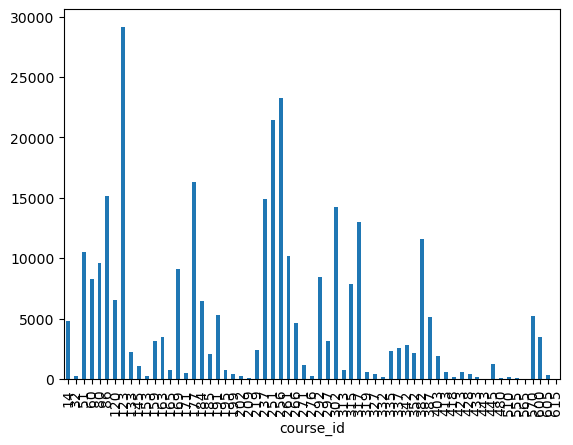

In [34]:

# Number of ratings per course
data = user_item_rating.groupby('course_id')['rating'].count()
data.plot(kind="bar")

<Axes: xlabel='rating'>

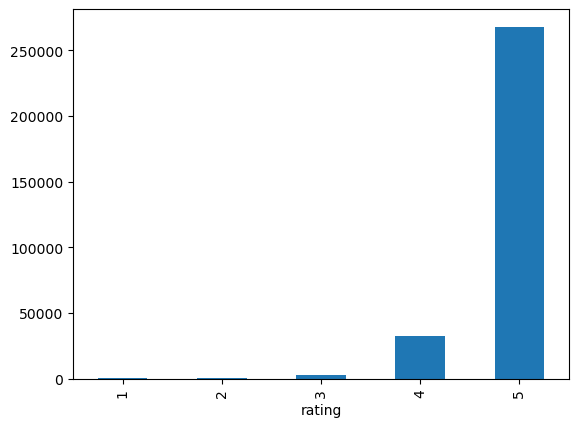

In [35]:
# Number of ratings per course
data = user_item_rating.groupby('rating')['rating'].count()
data.plot(kind="bar")

In [39]:
min_ratings = 5
filter_items = user_item_rating['course_id'].value_counts() > min_ratings
filter_items = filter_items[filter_items].index.tolist()

min_user_ratings = 5
filter_users = user_item_rating['user_id'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

user_item_rating_new = user_item_rating[(user_item_rating['course_id'].isin(filter_items)) & (user_item_rating['user_id'].isin(filter_users))]
print('The new data frame shape:\t{} | {} users | {} items'.format(user_item_rating.shape, 
                                                                   user_item_rating.user_id.nunique(), 
                                                                   user_item_rating.course_id.nunique()))

print('The new data frame shape:\t{} | {} users | {} items'.format(user_item_rating_new.shape, 
                                                                   user_item_rating_new.user_id.nunique(), 
                                                                   user_item_rating_new.course_id.nunique()))

#del user_item_rating

The new data frame shape:	(303956, 3) | 103395 users | 63 items
The new data frame shape:	(127540, 3) | 14059 users | 63 items


In [52]:
### Transforming data input to Surprise reader
surprise_reader = Reader(rating_scale=(1, 5))
surprise_data_user_item = Dataset.load_from_df(
    user_item_rating_new[["user_id", "course_id", "rating"]],
    surprise_reader)

In [47]:
result_data = list()
# Iterate over all algorithms

algorithms = [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), 
              KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]

print ("Attempting: ", str(algorithms), '\n\n\n')

for algorithm in algorithms:
    print("Starting: " ,str(algorithm))
    # Perform cross validation
    results = cross_validate(algorithm, surprise_data_user_item, measures=['RMSE'], cv=3, verbose=False)
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp['Algorithm'] = str(algorithm).split(' ')[0].split('.')[-1]
    
    result_data.append(tmp)
    
    print("Done: " ,str(algorithm), "\n\n")

print ('\n\tDONE\n')


Attempting:  [<surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7f881883c7c0>, <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x7f881883c040>, <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x7f881883c3d0>, <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x7f8818c02fb0>, <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x7f8818c039d0>, <surprise.prediction_algorithms.knns.KNNBaseline object at 0x7f8818c03190>, <surprise.prediction_algorithms.knns.KNNBasic object at 0x7f8818c03880>, <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x7f8818c011e0>, <surprise.prediction_algorithms.knns.KNNWithZScore object at 0x7f8818c01d50>, <surprise.prediction_algorithms.baseline_only.BaselineOnly object at 0x7f8818c03790>, <surprise.prediction_algorithms.co_clustering.CoClustering object at 0x7f8818c02e00>] 



Starting:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7f88188

In [51]:
surprise_results = pd.DataFrame(result_data).set_index('Algorithm').sort_values('test_rmse')
surprise_results.sort_values(by=['test_rmse','test_time'],ascending=[True,True])

,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.321454,1.501309,0.721498
KNNWithZScore,0.323310,15.255740,66.436310
KNNWithMeans,0.325446,14.708145,71.688398
SlopeOne,0.325909,0.174303,0.419471
KNNBaseline,0.326353,14.263496,68.263306
SVD,0.327156,1.164259,0.225333
BaselineOnly,0.336015,0.369289,0.300254
CoClustering,0.339032,2.479557,0.140700
KNNBasic,0.342948,14.239703,71.460675
